In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler 
import csv

#problem: contains many nans. before using pandas we need to know how to handle it.
def read_df(path=""):
    return pd.read_table(path+"case1Data.txt", delimiter=",")


def read_var_names(path=""):
    with open(path+'var_names.txt', newline='') as f:
        reader = csv.reader(f)
        var_names = list(reader)
    var_names = var_names[0]
    names = [x.replace(" ","").replace("_","") for x in var_names]
    return names


def update_plt_cfg():
    SMALL_SIZE = 8
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 16
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def split_data(df):
    dfNumeric = df.iloc[:, :96]
    dfCategorical = df.iloc[:, 96:]
    return dfNumeric, dfCategorical

def convertNumeric(df):
    #fix it so NaNs are not strings but rather np.NaN
    for col in df.columns:
        df[col]=pd.to_numeric(df[col], errors="coerce")
    return df

def missingValueInformation(df,plot=False):
    #checks the number of rows / cols with minimally one missing value
    #input:   numeric pandas df
    #returns: two pandas series objects for illustration.
    #           - the distribution of nans across variables
    #           - the distribution of nans across observations

    #obtain distribution as pandas series
    variable_nan_distribution = np.sum(np.isnan(df),axis=0)
    obs_nan_distribution = np.sum(np.isnan(df),axis=1)

    #check for minimally one value
    obs_min_one_missing = sum(df.apply(lambda x: sum(x.isnull().values), axis = 1)>0)
    var_min_one_missing = sum(df.apply(lambda x: sum(x.isnull().values), axis = 0)>0)
    print(f"At least one missing value occuring in {var_min_one_missing}/{df.shape[1]} variables")
    print(f"At least one missing value occuring in {obs_min_one_missing}/{df.shape[0]} observations")

    #mean number of missing values 
    print(f"Mean count missing per variable {np.mean(variable_nan_distribution)}")
    print(f"Mean count missing per observation {np.mean(obs_nan_distribution)}")
    

    #fix pandas series so it is easily plottable using seaborn
    variable_nan_distribution = variable_nan_distribution.rename_axis("variable").reset_index(name="count")
    obs_nan_distribution =  obs_nan_distribution.rename_axis("observation").reset_index(name="count")
    if(plot==True):
        missingValuePlots(variable_nan_distribution,obs_nan_distribution)

    return variable_nan_distribution, obs_nan_distribution


def missingValuePlots(var_df,obs_df,path="plots"):
    fig, ax = plt.subplots(2,1,figsize=(18,12))
    #fig.suptitle("number of missing values per variable")
    #plt.xticks(rotation=90)
    b1 = sns.barplot(data=var_df,x="variable",y="count",ax=ax[0])
    b2 = sns.barplot(data=obs_df,x="observation",y="count",ax=ax[1])
    for ax_ in ax:
        for tick in ax_.get_xticklabels():
            tick.set_rotation(90)
    ax[0].set_title("Missing values across variables",fontweight="bold",fontsize=16)
    ax[1].set_title("Missing values across observations",fontweight="bold",fontsize=16)
    
    fig.tight_layout()
    plt.show()
    if(path=="plots"):
        fig.savefig('plots/missing_values.png')
    else:
        fig.savefig('missing_values.png')
    return None

def standardize_col(column):
    return (column - column.mean()) / column.std()

def standardize_df(df):
    scaler = StandardScaler() 
    df2 = scaler.fit_transform(df) 
    return df2

def printHighCorrelations(corrdf, k = 3):
    #prints and returns the three highest correlations per variable
    var_names = read_var_names()
    corrdf -= np.identity(corrdf.shape[0])*100.0 #kill diagonals just to be sure
    corrdf *= np.tri(*corrdf.shape) #kill upper triangular to 0.0  
    #get top three correlations
    completeMax = np.argmax(corrdf,axis=0)

    #print(corrdf)
    ind = np.argsort(corrdf,axis=0) #sort array along rows in ascending order, keep indices of argmax
    #print(ind)
    ind = ind[-k:,:] 
    #print(ind)
    for var in range(ind.shape[1]):
        print(f"{var_names[var]}")
        for maxInd in ind[:,var]:
            print(f"\tcorr with {var_names[maxInd]}: {corrdf[maxInd,var]}")
    return
    


def covariance_plot(df,title=None,covAnalysis=False):
    df_standardized = df.apply(standardize_col) 
    covs = df_standardized.cov().to_numpy()
    corrs = df_standardized.corr(numeric_only=True).to_numpy()
    fig, ax = plt.subplots(2,1,figsize=(10,10))
    covIm = ax[0].imshow(covs,cmap="viridis")
    #plt.colorbar(covIm,ax=ax[0])
    ax[0].set_title("Cov: " + title)
    plt.colorbar(covIm,fraction=0.046, pad=0.04)
    
    corrIm = ax[1].imshow(corrs,cmap="viridis")
    #cax = fig.add_axes([ax[1].get_position().x1-0.25,ax[1].get_position().y0,0.02,ax[0].get_position().y1-ax[1].get_position().y0])
    #fig.colorbar(covIm, cax=cax)
    plt.colorbar(corrIm,fraction=0.046, pad=0.04)
    ax[1].set_title("Corr: " + title)



    if(covAnalysis):
        printHighCorrelations(corrs)
    return 


#def standardize_data(df):


/tmp/ipykernel_628/4206607406.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


At least one missing value occuring in 95/96 variables
At least one missing value occuring in 100/100 observations
Mean count missing per variable 14.385416666666666
Mean count missing per observation 13.81


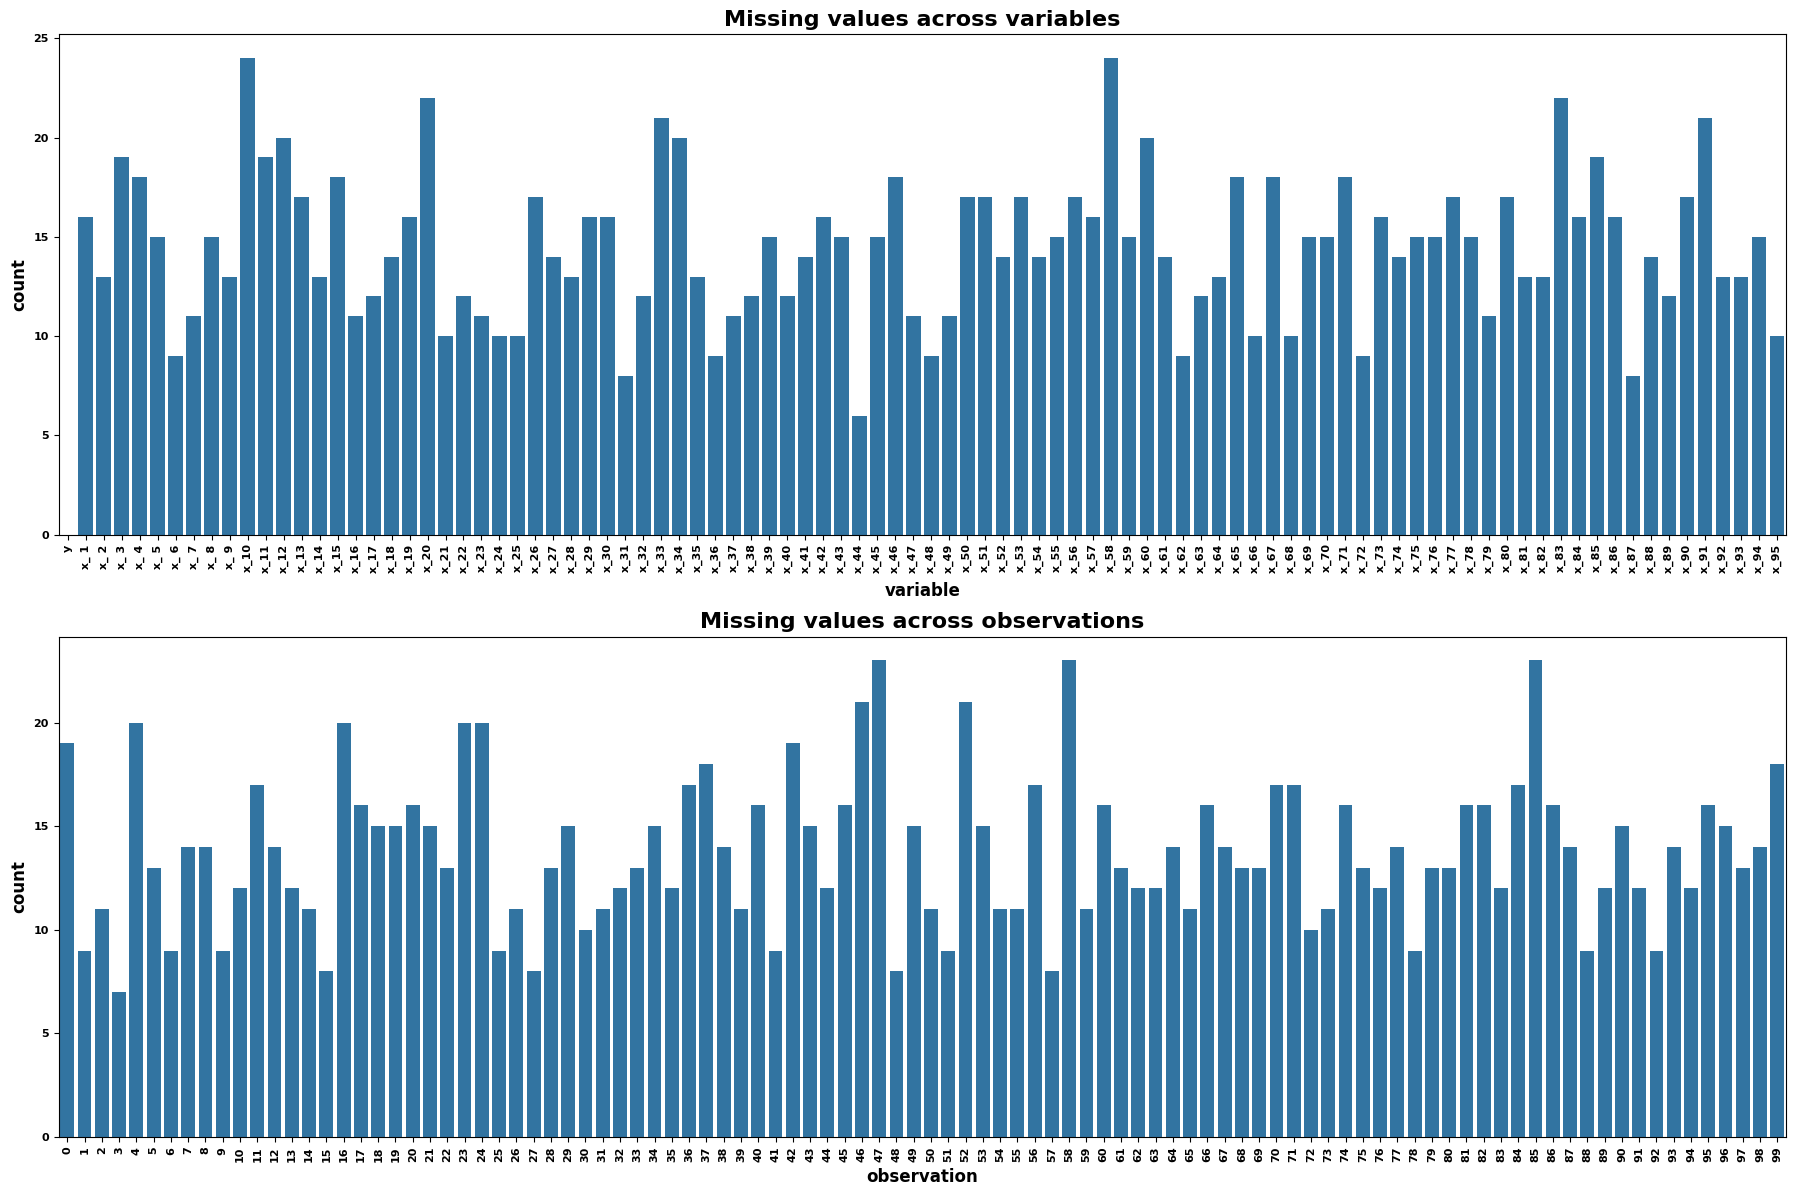

In [3]:
update_plt_cfg()
train_data = read_df()
numeric_df, categorical_df = split_data(train_data)
numeric_df = convertNumeric(numeric_df)
var_missing_dist,obs_nan_dist = missingValueInformation(numeric_df,plot=True)

y
	corr with x54: 0.6153796658722872
	corr with x3: 0.6233595943662354
	corr with x62: 0.6876715009638525
x1
	corr with x70: 0.5846372352505764
	corr with x60: 0.5901853817612015
	corr with x16: 0.6086568661736248
x2
	corr with x84: 0.5550107585094094
	corr with x33: 0.5643219621942995
	corr with x59: 0.6759618187649605
x3
	corr with x46: 0.6180585329346066
	corr with x61: 0.6502427893719482
	corr with x54: 0.6622619118720513
x4
	corr with x82: 0.5610249433699918
	corr with x71: 0.5767069036949087
	corr with x92: 0.6022421031989788
x5
	corr with x39: 0.631622581443235
	corr with x46: 0.6375958096364382
	corr with x64: 0.6407673284038077
x6
	corr with x46: 0.581271898797597
	corr with x54: 0.5841345261342036
	corr with x28: 0.6522980160647383
x7
	corr with x18: 0.5599847073474747
	corr with x89: 0.5739943944594884
	corr with x9: 0.5839098598084752
x8
	corr with x46: 0.6264287574164864
	corr with x70: 0.6355188587519772
	corr with x68: 0.6471353292483141
x9
	corr with x10: 0.644803885026

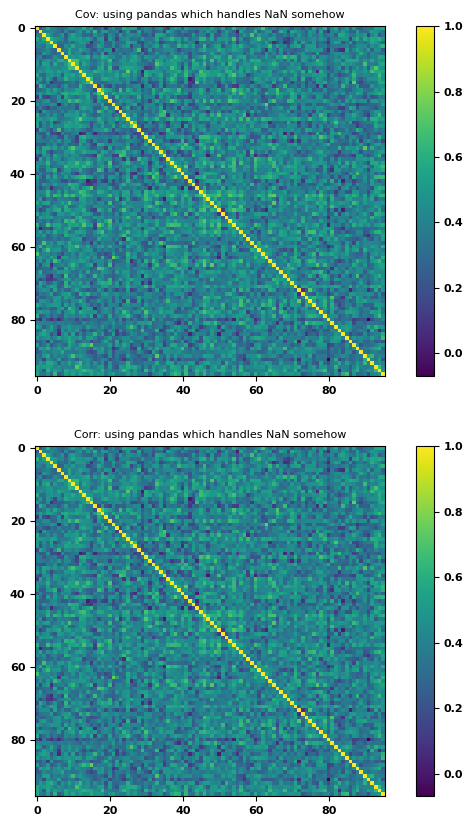

In [4]:
#norm_df = numeric_df.copy(deep=True)
#print(standardize_df(norm_df))
covariance_plot(numeric_df,title="using pandas which handles NaN somehow",covAnalysis=True)

In [5]:
printHighCorrelations(np.arange(0,16,dtype="float").reshape(4,4),k=2)

y
	corr with x2: 8.0
	corr with x3: 12.0
x1
	corr with x2: 9.0
	corr with x3: 13.0
x2
	corr with x1: 0.0
	corr with x3: 14.0
x3
	corr with x1: 0.0
	corr with x2: 0.0


In [6]:
#test = np.arange(0,16,dtype="float").reshape(4,4)
#np.argpartition(test,-3)[-3:]

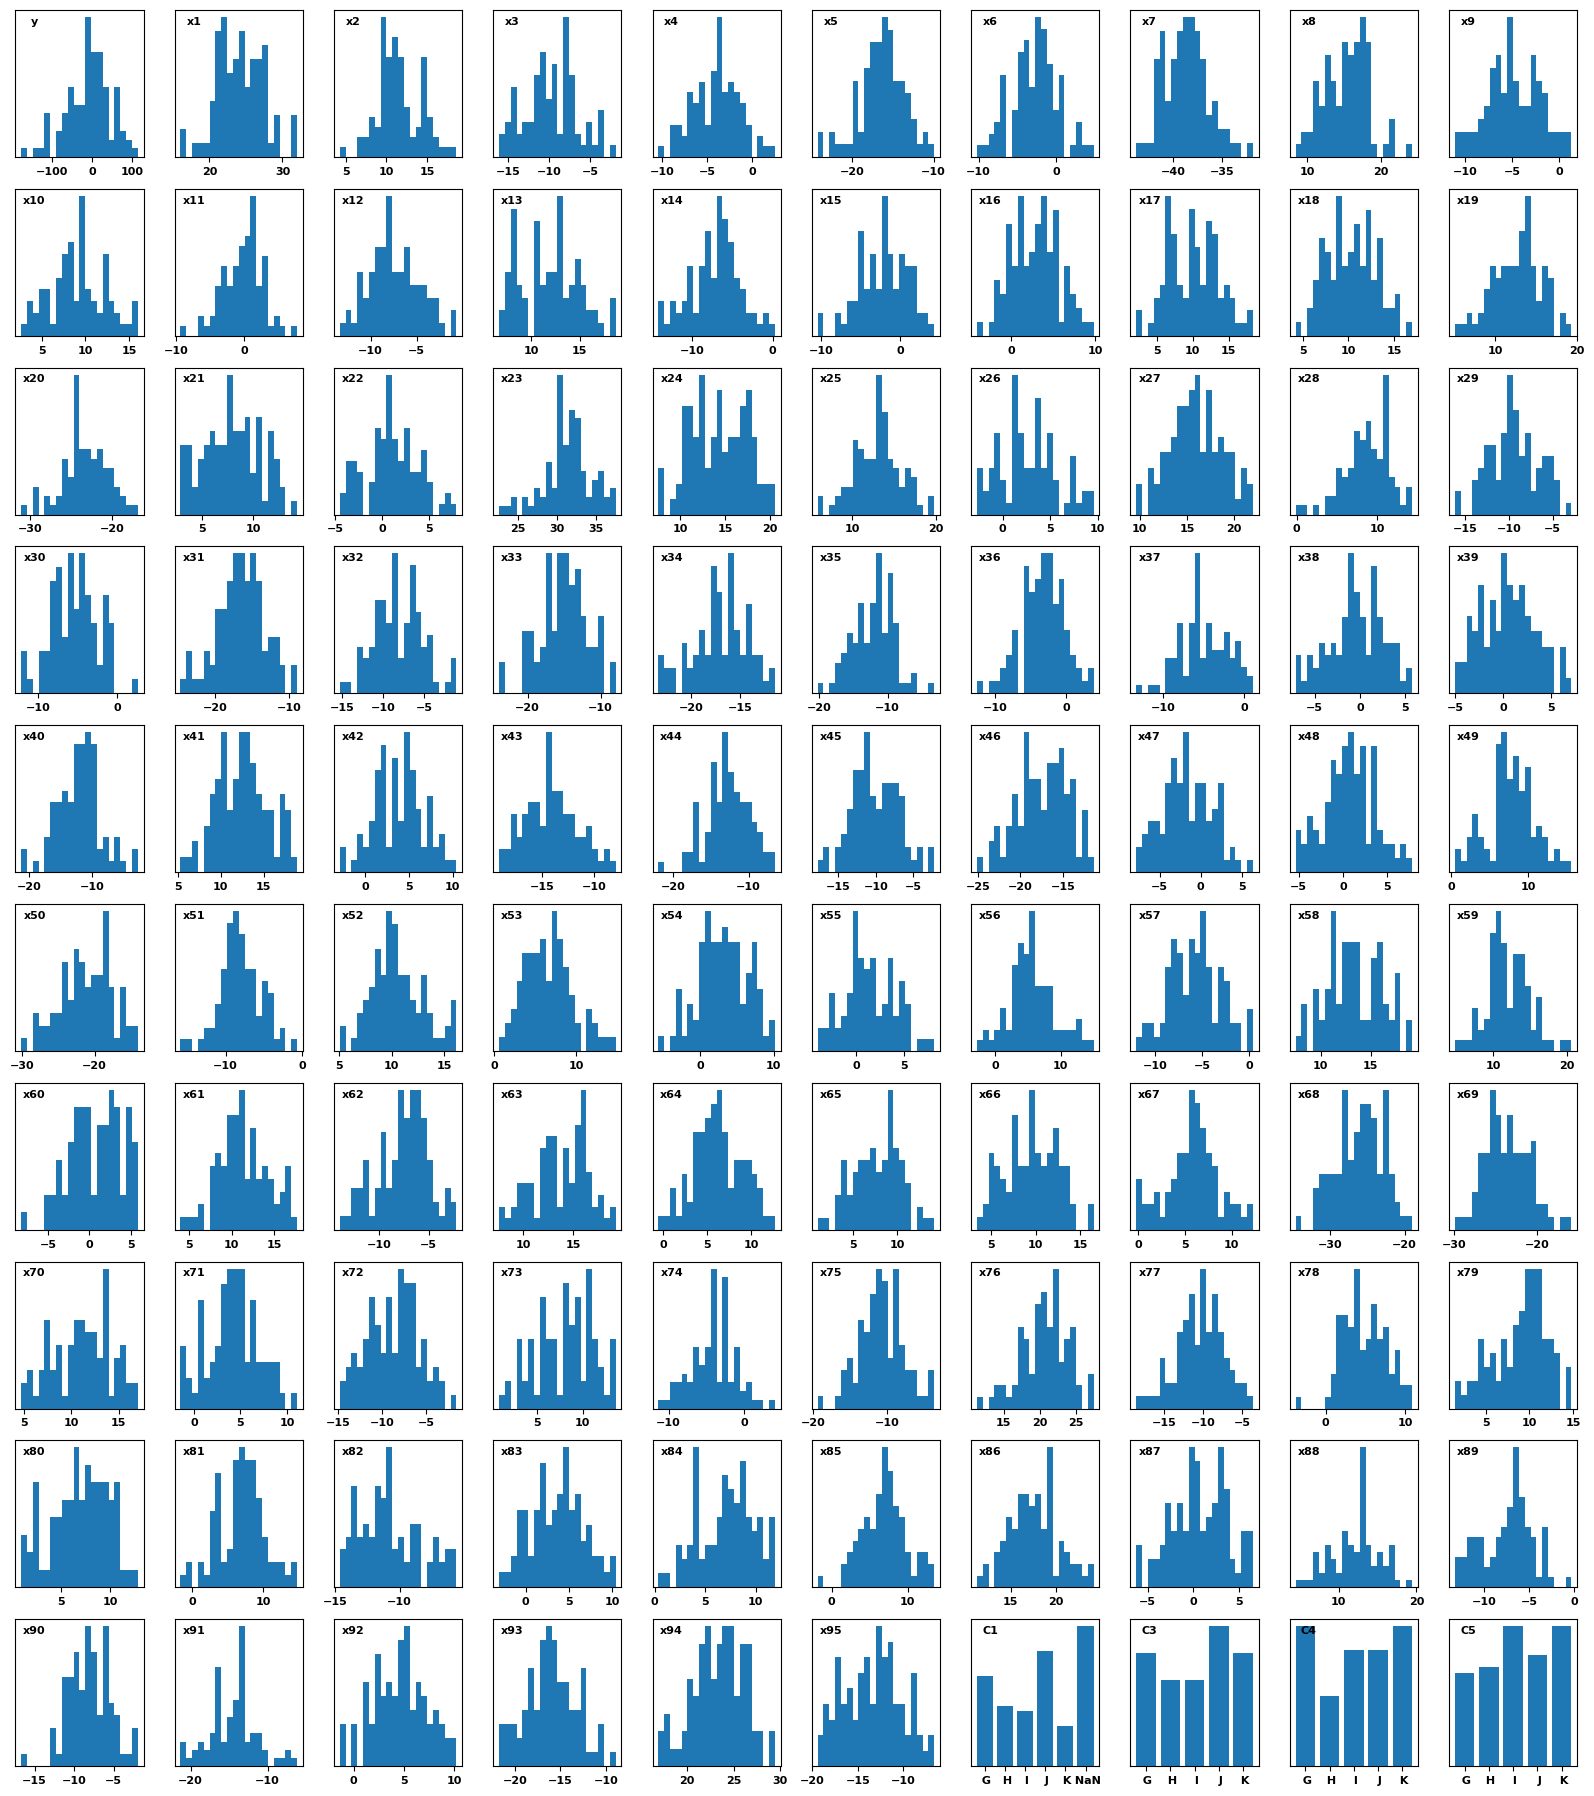

In [66]:
def plotDataDistribution(numeric_df,categorical_df):
    #def plot_distributions(numeric_data,categorical_data):
    [n,p_numeric] = numeric_df.shape
    fig, axs = plt.subplots(10,10,figsize=(16,18))
    df_np = numeric_df.to_numpy()
    df_cat_np = categorical_df.to_numpy()
    df_cat_np = np.concatenate((df_cat_np[:,0,None],df_cat_np[:,2:]),axis=1) #remove C_2 as it is not informative except possibly NaN?
    labels = read_var_names()
    labels.remove("C2") #remove C_2 from labels 

    for p, ax in enumerate(axs.ravel()):
        if(p>=p_numeric): #used all numeric data-frames, plot distribution of categorical excluding feature which only contains H
            unique, counts = np.unique(df_cat_np[:,p-p_numeric],return_counts=True)
            ax.bar(x=unique,height=counts)
        else:
            ax.hist(x=df_np[:,p],bins=20,density=True)
            
        ax.text(.15,.9,f'{labels[p]}',
            horizontalalignment='center',
            transform=ax.transAxes)
        ax.set_yticks([])

    #fig.tight_layout()    
    plt.show()
    
    #fig.savefig("dataDistribution.png")
    return None

    

plotDataDistribution(numeric_df,categorical_df)

 

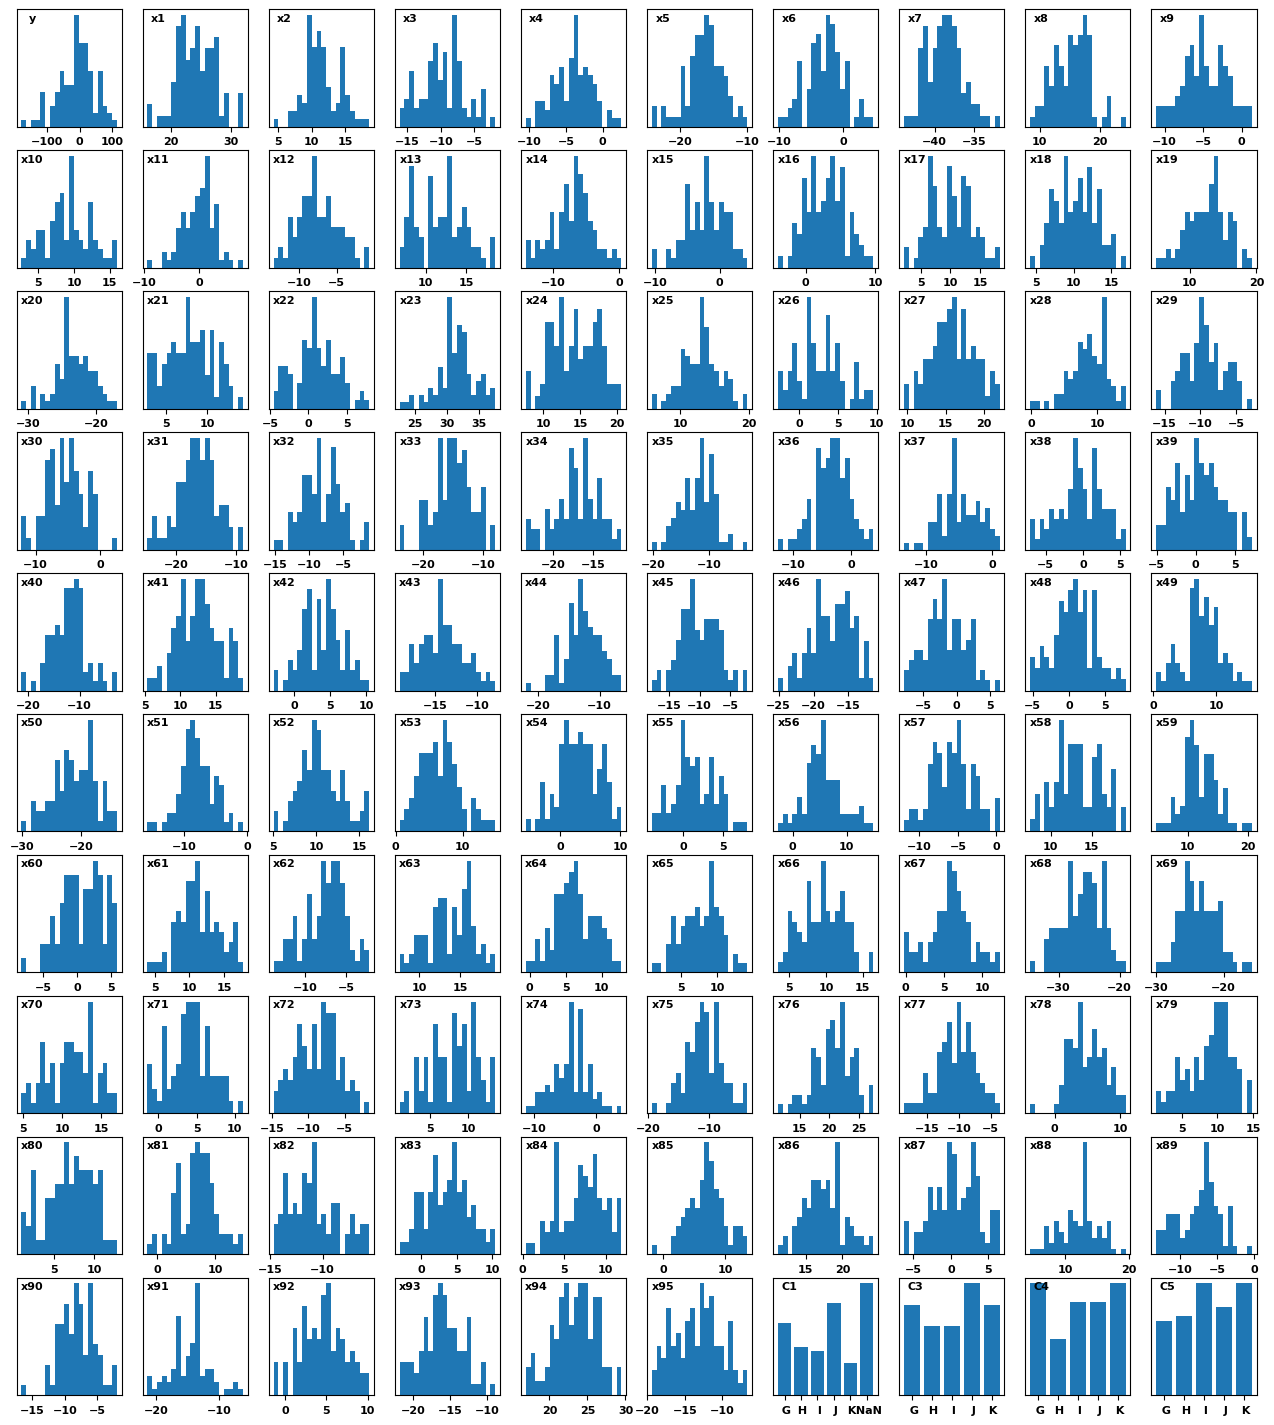

In [61]:
#def plot_distributions(numeric_data,categorical_data):
[n,p_numeric] = numeric_df.shape

fig, axs = plt.subplots(10,10,figsize=(16,18))

df_np = numeric_df.to_numpy()
df_cat_np = categorical_df.to_numpy()
df_cat_np = np.concatenate((df_cat_np[:,0,None],df_cat_np[:,2:]),axis=1) #remove C_2 as it is not informative except possibly NaN?
labels = read_var_names()
labels.remove("C2")

for p, ax in enumerate(axs.ravel()):
    if(p>=p_numeric): #used all numeric data-frames, plot distribution of categorical excluding feature which only contains H
        unique, counts = np.unique(df_cat_np[:,p-p_numeric],return_counts=True)
        ax.bar(x=unique,height=counts)
    else:
        ax.hist(x=df_np[:,p],bins=20,density=True)
        
    ax.text(.15,.9,f'{labels[p]}',
        horizontalalignment='center',
        transform=ax.transAxes)
    ax.set_yticks([])
    
plt.show()
        

 

In [53]:
labels[-5:]

['C1', 'C2', 'C3', 'C4', 'C5']

In [50]:
df_cat_np = categorical_df.to_numpy()
for i in range(df_cat_np.shape[1]):
    print(np.unique(df_cat_np[:,i]))

[' G' ' H' ' I' ' J' ' K' ' NaN']
[' H']
[' G' ' H' ' I' ' J' ' K']
[' G' ' H' ' I' ' J' ' K']
[' G' ' H' ' I' ' J' ' K']


[' G' ' H' ' I' ' J' ' K' ' NaN'] [18 12 11 23  8 28]


<BarContainer object of 6 artists>

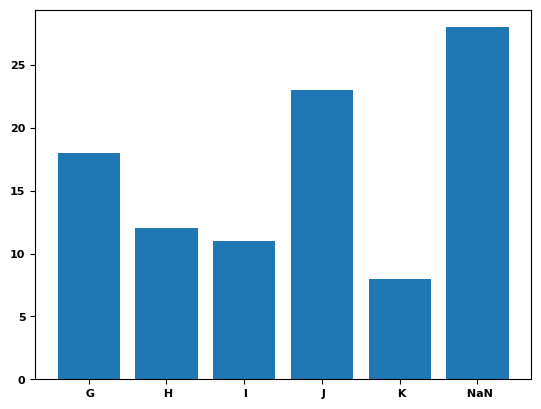

In [37]:
test = categorical_df.to_numpy()[:,0]
unique, counts = np.unique(test,return_counts=True)
plt.bar(x=unique,height=counts)

(array([ 2.,  0.,  1.,  1.,  0.,  1.,  4.,  3., 10.,  6.,  5.,  3., 11.,
         4.,  4.,  6.,  4.,  6.,  7.,  0.,  2.,  1.,  0.,  1.,  2.]),
 array([16.031508  , 16.66991636, 17.30832472, 17.94673308, 18.58514144,
        19.2235498 , 19.86195816, 20.50036652, 21.13877488, 21.77718324,
        22.4155916 , 23.05399996, 23.69240832, 24.33081668, 24.96922504,
        25.6076334 , 26.24604176, 26.88445012, 27.52285848, 28.16126684,
        28.7996752 , 29.43808356, 30.07649192, 30.71490028, 31.35330864,
        31.991717  ]),
 <BarContainer object of 25 artists>)

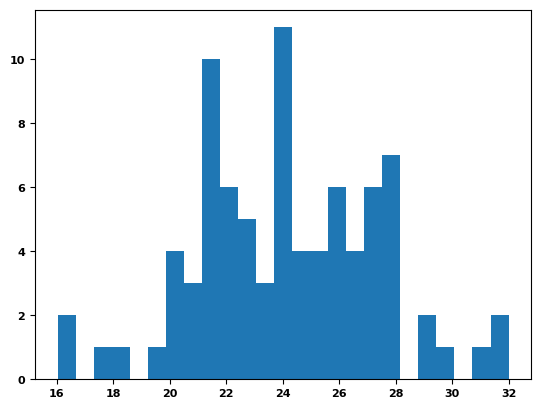

In [18]:
plt.hist(x=numeric_df.to_numpy()[:,1],bins=25)